# Fourier analysis on file.csv

In this notebook we apply a fourier analysis to the number of sales per category per day.

We use the fourier analysis to "detrend" the data and find underlying paterns in sales behaviour. The Fourier analysis is appropriate here as sales data tends to be cyclical. (for further exploration of this we read https://journals.sagepub.com/doi/10.5772/56839)

Using this detrended version we perform k-means clustering to find different types of product categories.

This may be usefull for the purpose of making stocking decision in a brick and mortar store or other logistical consideration for online stores.

# setup

**imports**

We use the standard scientific analysis libraries numpy, pyplot and pandas.

**file definitions**

We define the filename and column names of interest to make it easier to apply this notebook to other datasets.

**analysis settings**

Lastly we define our variables for the number of days to use for our roling average and the number of components of the fourier anlysis we expect to be trend related.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# description of the underlying dataset
FILENAME = "data/file.csv"
DATE_COLUMN_NAME = "Transaction_Date"
CATEGORY_COLUMN_NAME = "Product_Category"

# settings for:
#   the rolling average days (we set this to 7 to account for differences per weekday)
#   the number of components we take as trend components 
ROLING_AVG_DAYS = 7
FOURIER_COMPONENTS = 5

First we read in the data of the sales numbers per day using a pandas crosstab. 

One thing this misses is that some transactions may have more then one of the item contained in them. Beacause some of our datasets have this field and some don't we decided to look at the number of transaclions and not the number of items sold.

The data is for one year from 2019-01-01 up to and including 2019-12-31

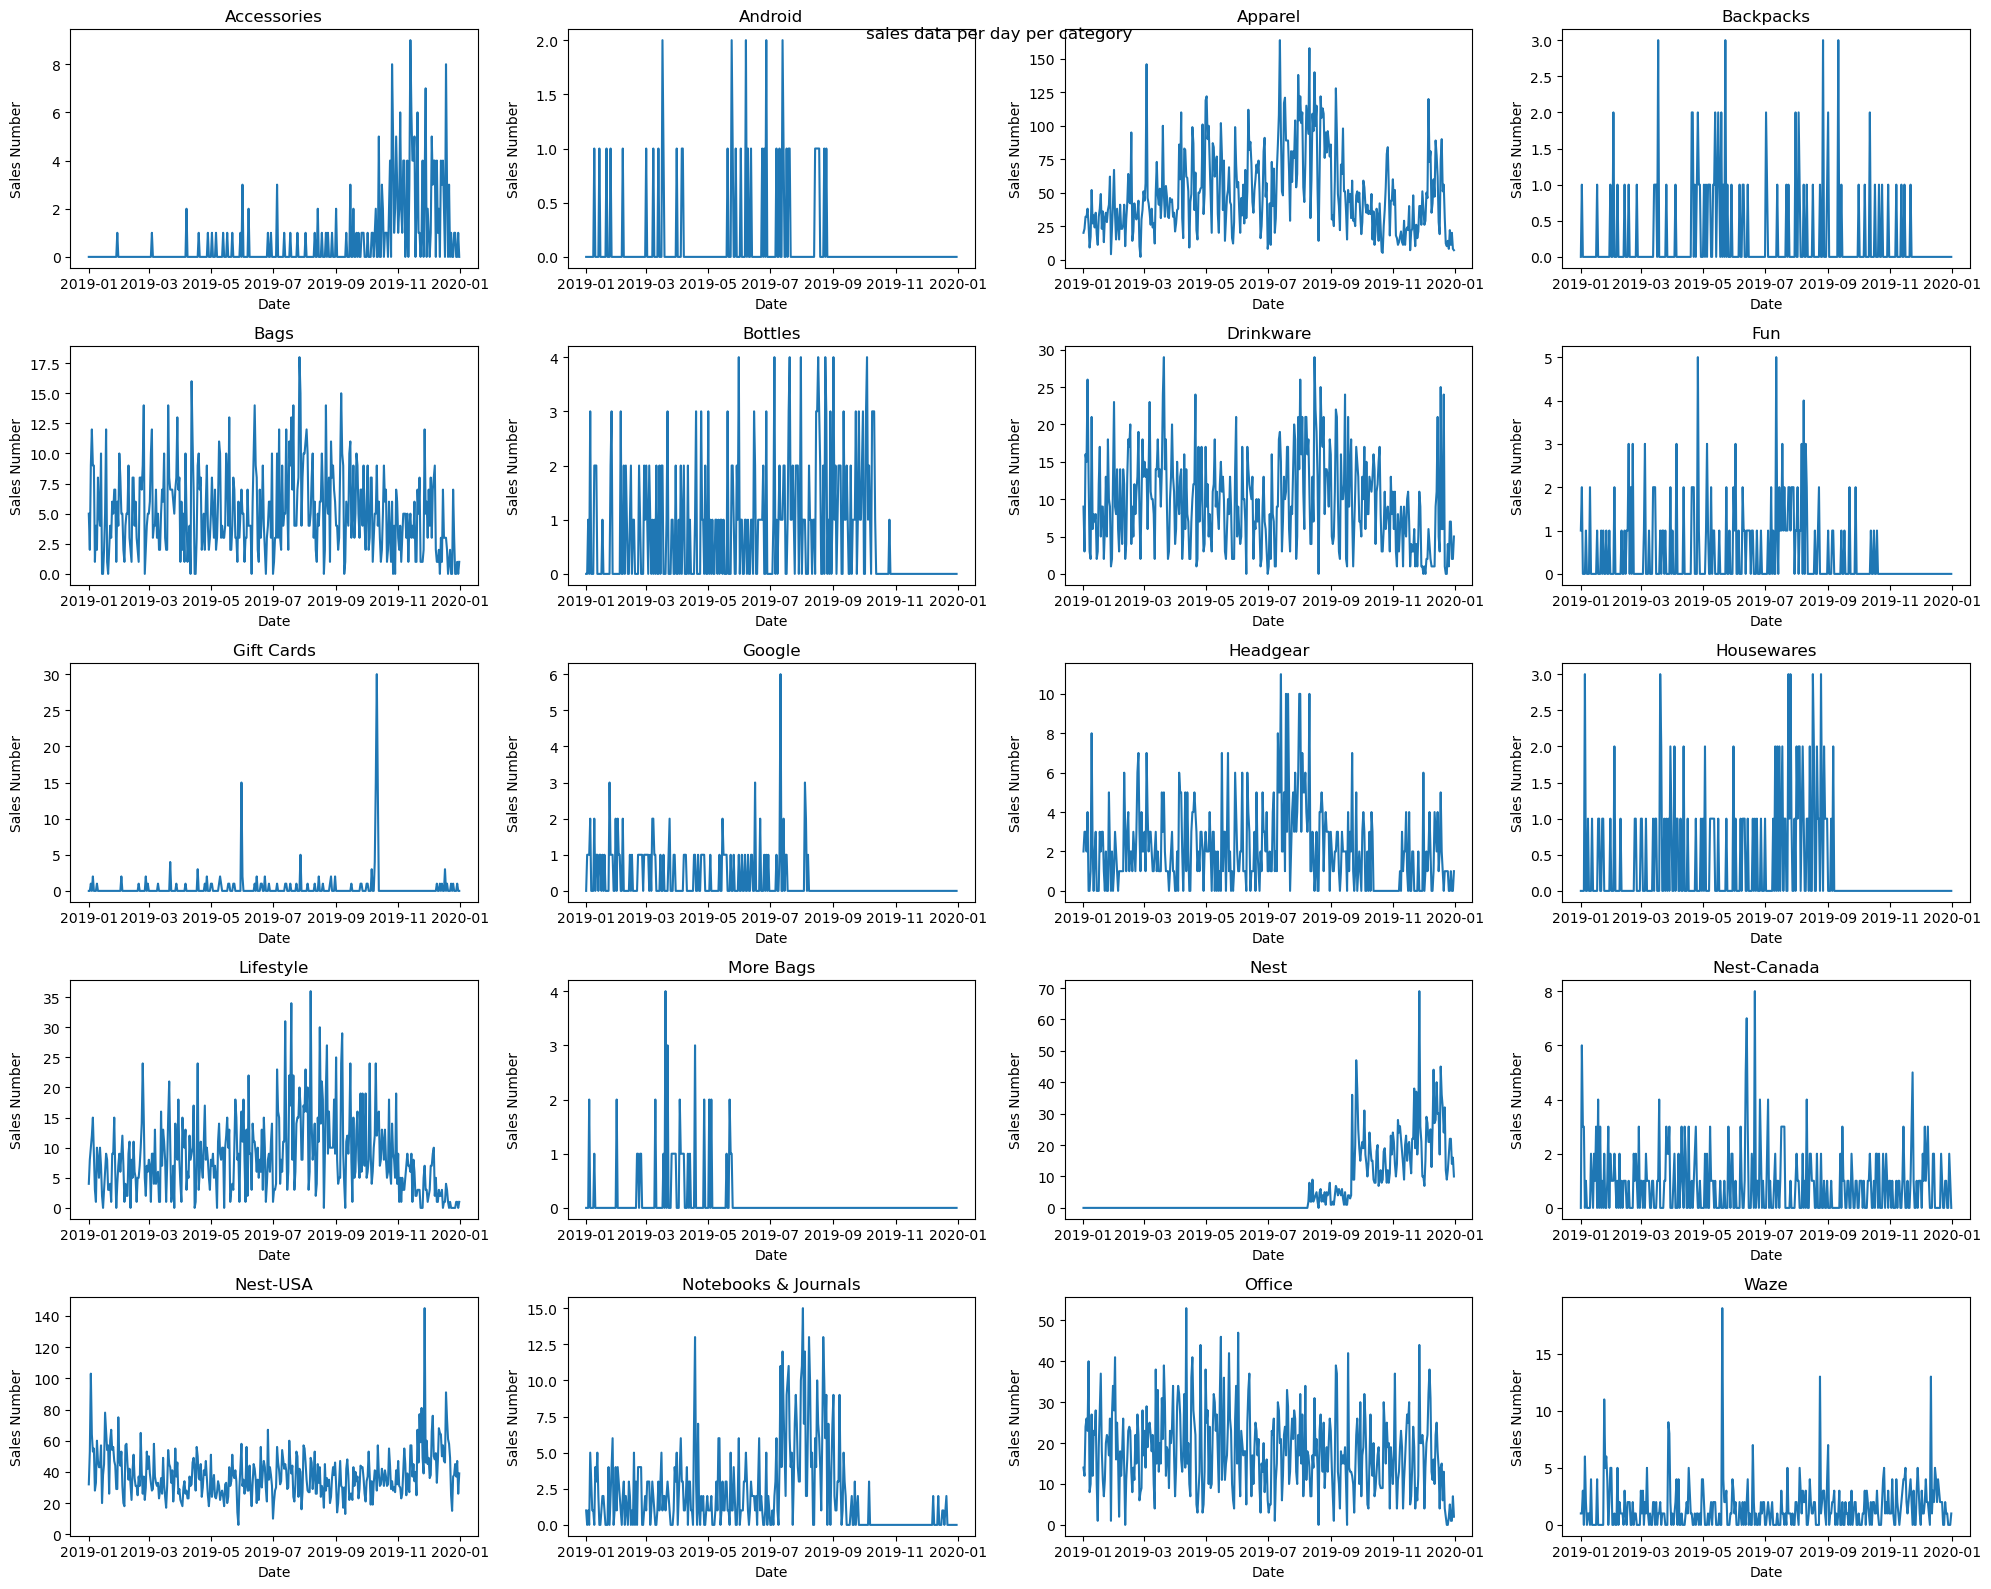

In [2]:
# read in the data
df = pd.read_csv(FILENAME, parse_dates=[DATE_COLUMN_NAME])
# aggregate by date
df_per_day = pd.crosstab(df[DATE_COLUMN_NAME].dt.date,
                            df[CATEGORY_COLUMN_NAME])
# sort for certainty (should not be necesary)
df_per_day = df_per_day.sort_index()

# now we plot this per category
data = df_per_day.to_numpy()
fig, axs = plt.subplots(5, 4, figsize=(20, 16))
for x in range(5):
    for y in range(4):
        index = 4 * x + y
        sub_data = data.T[index]
        axs[x, y].plot(df_per_day.index, sub_data)
        axs[x, y].set_xlabel("Date")
        axs[x, y].set_ylabel("Sales Number")
        axs[x, y].set_title(df_per_day.columns[index])
fig.align_labels()
plt.tight_layout()
plt.suptitle(f"sales data per day per category")
plt.show()

We see that this data is very noisy and we thus cant see the trend very well. This may be due to high variability in the day of the week that an item is bought or due to special events (we see a clear peak arround black friday). 

To compensate for this take a roling average of 7 days to smooth the line. This still contains enoguh information for a seller to use to implement stocking decisions. This gives us a nice starting of point for our analysis. 

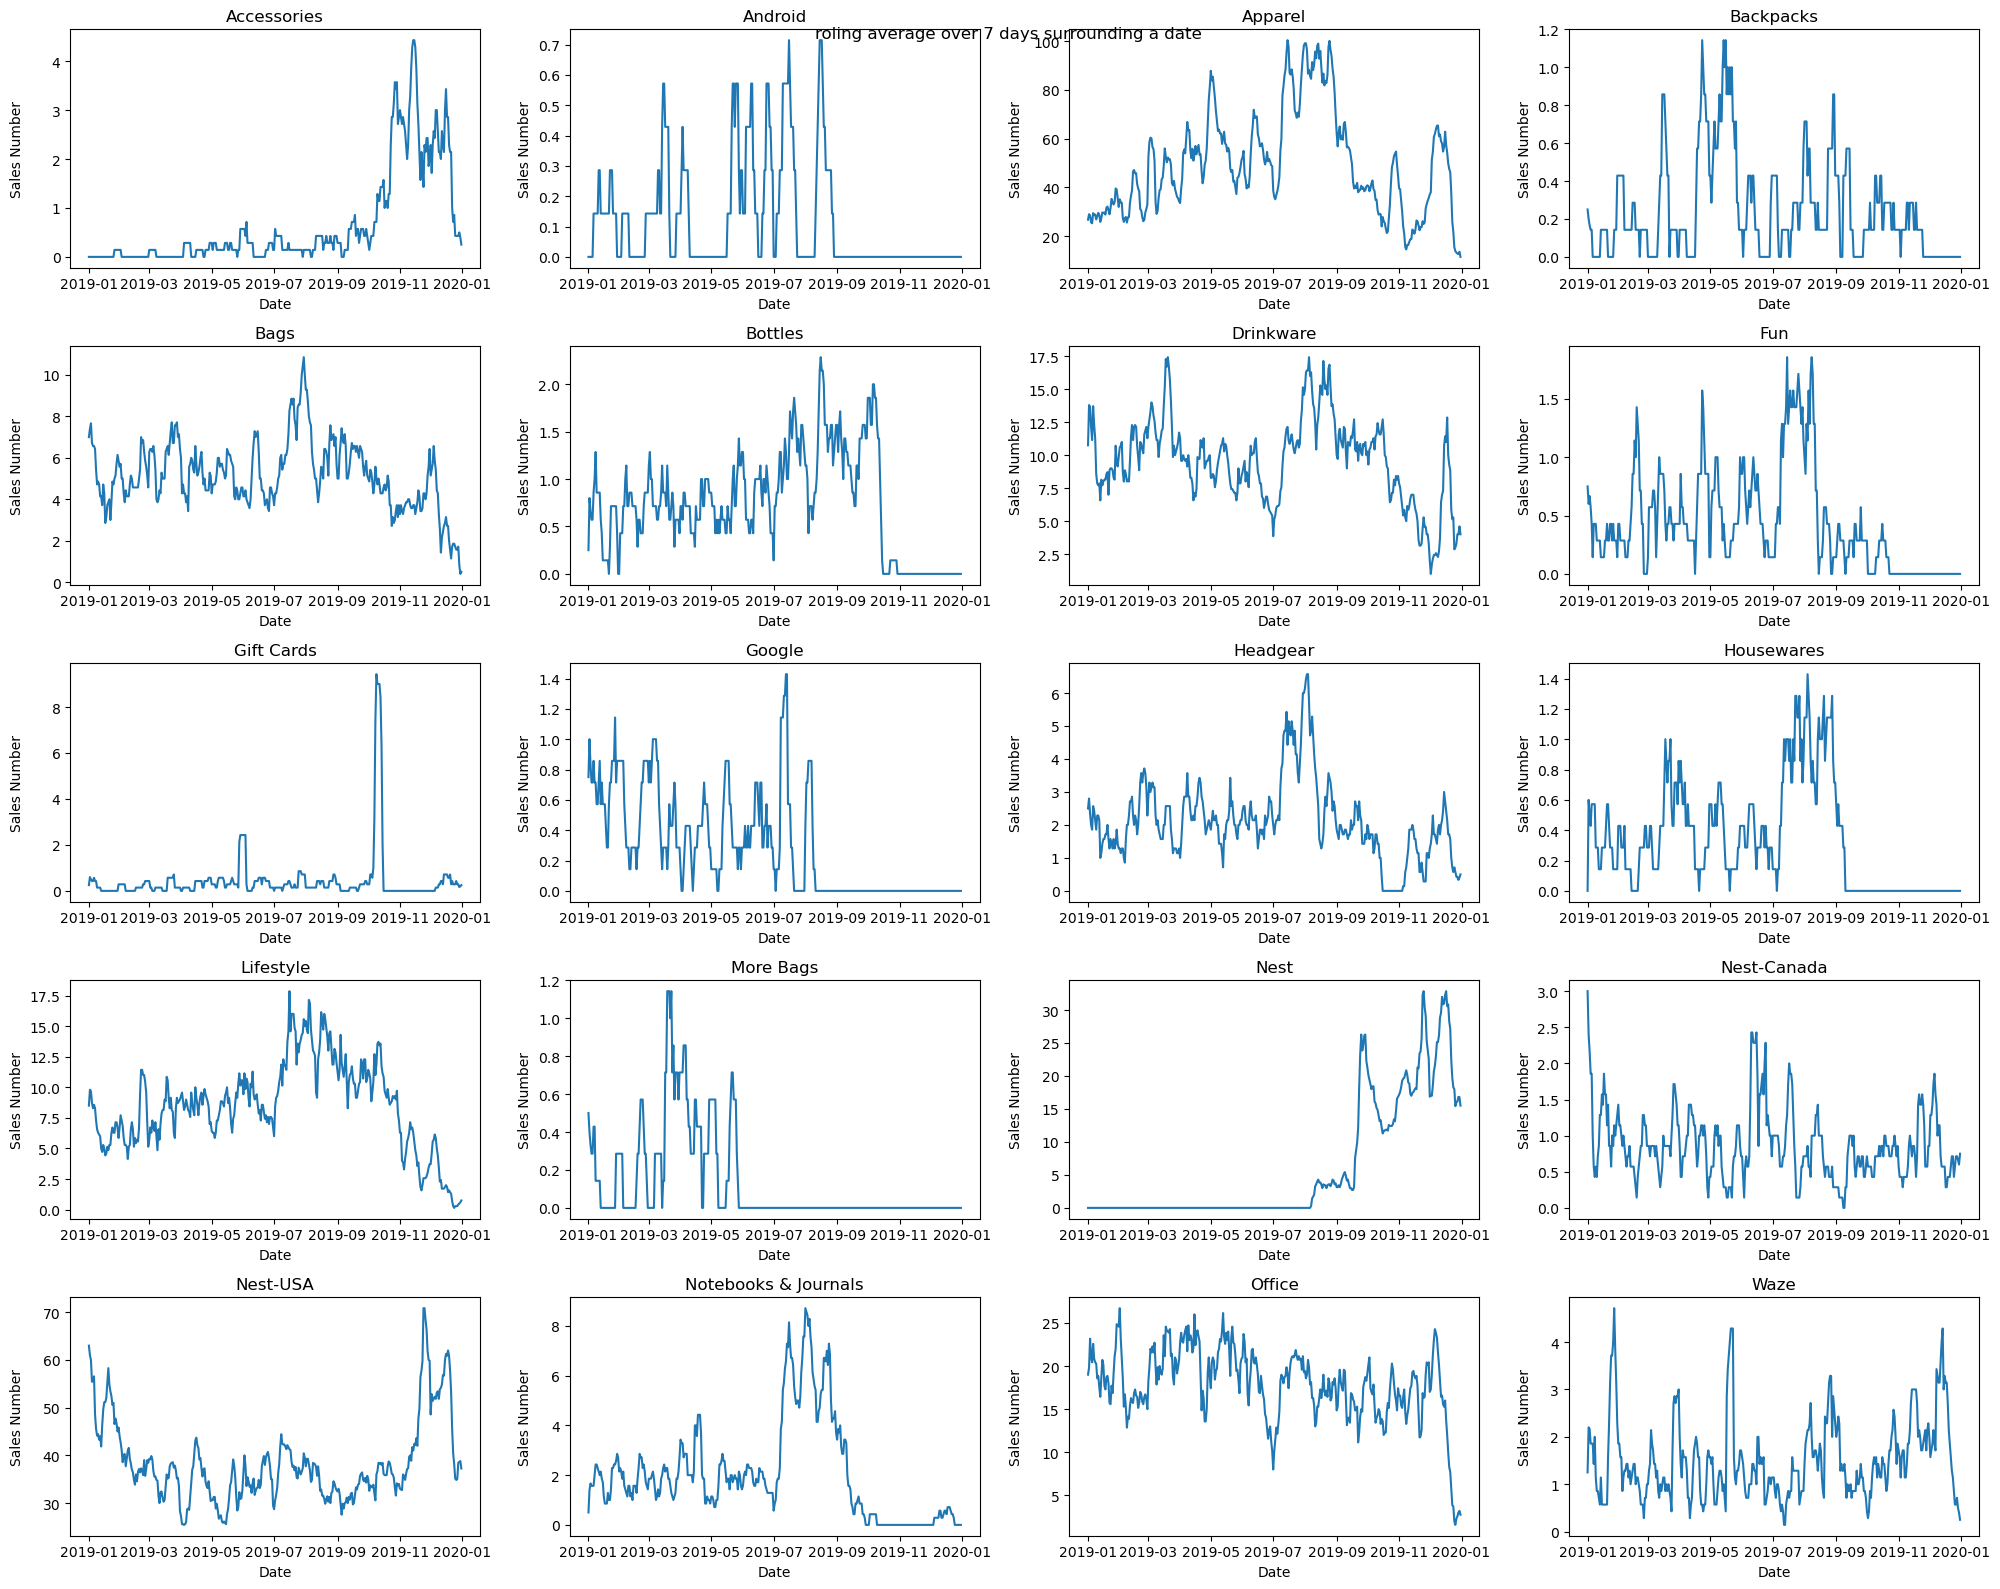

In [3]:
# get a roling average centering around the the day in question and ignoring missing values at the edges
df_rolling_avg = df_per_day.rolling(window=ROLING_AVG_DAYS,
                                    center=True,
                                    min_periods=1).mean()
df_rolling_avg = df_rolling_avg.dropna()

# now we plot this roling average
data = df_rolling_avg.to_numpy()
fig, axs = plt.subplots(5, 4, figsize=(20, 16))
for x in range(5):
    for y in range(4):
        index = 4 * x + y
        sub_data = data.T[index]
        axs[x, y].plot(df_rolling_avg.index, sub_data)
        axs[x, y].set_xlabel("Date")
        axs[x, y].set_ylabel("Sales Number")
        axs[x, y].set_title(df_rolling_avg.columns[index])
fig.align_labels()
plt.tight_layout()
plt.suptitle(f"roling average over {ROLING_AVG_DAYS} days surrounding a date")
plt.show()

# Detrending the data

Now we perform a fourier analysis on this data using the Fast Fourier Transform from numpy.

In [4]:
# we get the raw data from pandas as a numpy array to perform numpy.fft.fft() fit s
# data = df_per_day.to_numpy()
data = df_rolling_avg.to_numpy()

# we calculate the fourier fit for every category seperately
true_fourier_values = []
for index in range(20):
    # make a fourier fit
    fft_analysis = np.fft.fft(data.T[index])
    true_fourier_values.append(fft_analysis)
true_fourier_values = np.array(true_fourier_values)

If we were to plot this with all components of the fourier analysis we would get the original data back (which we don't want).

Therefore we should take only part of the components.

If we take the first values (those with higher magnitude) we get an approximation of the trend as seen below.

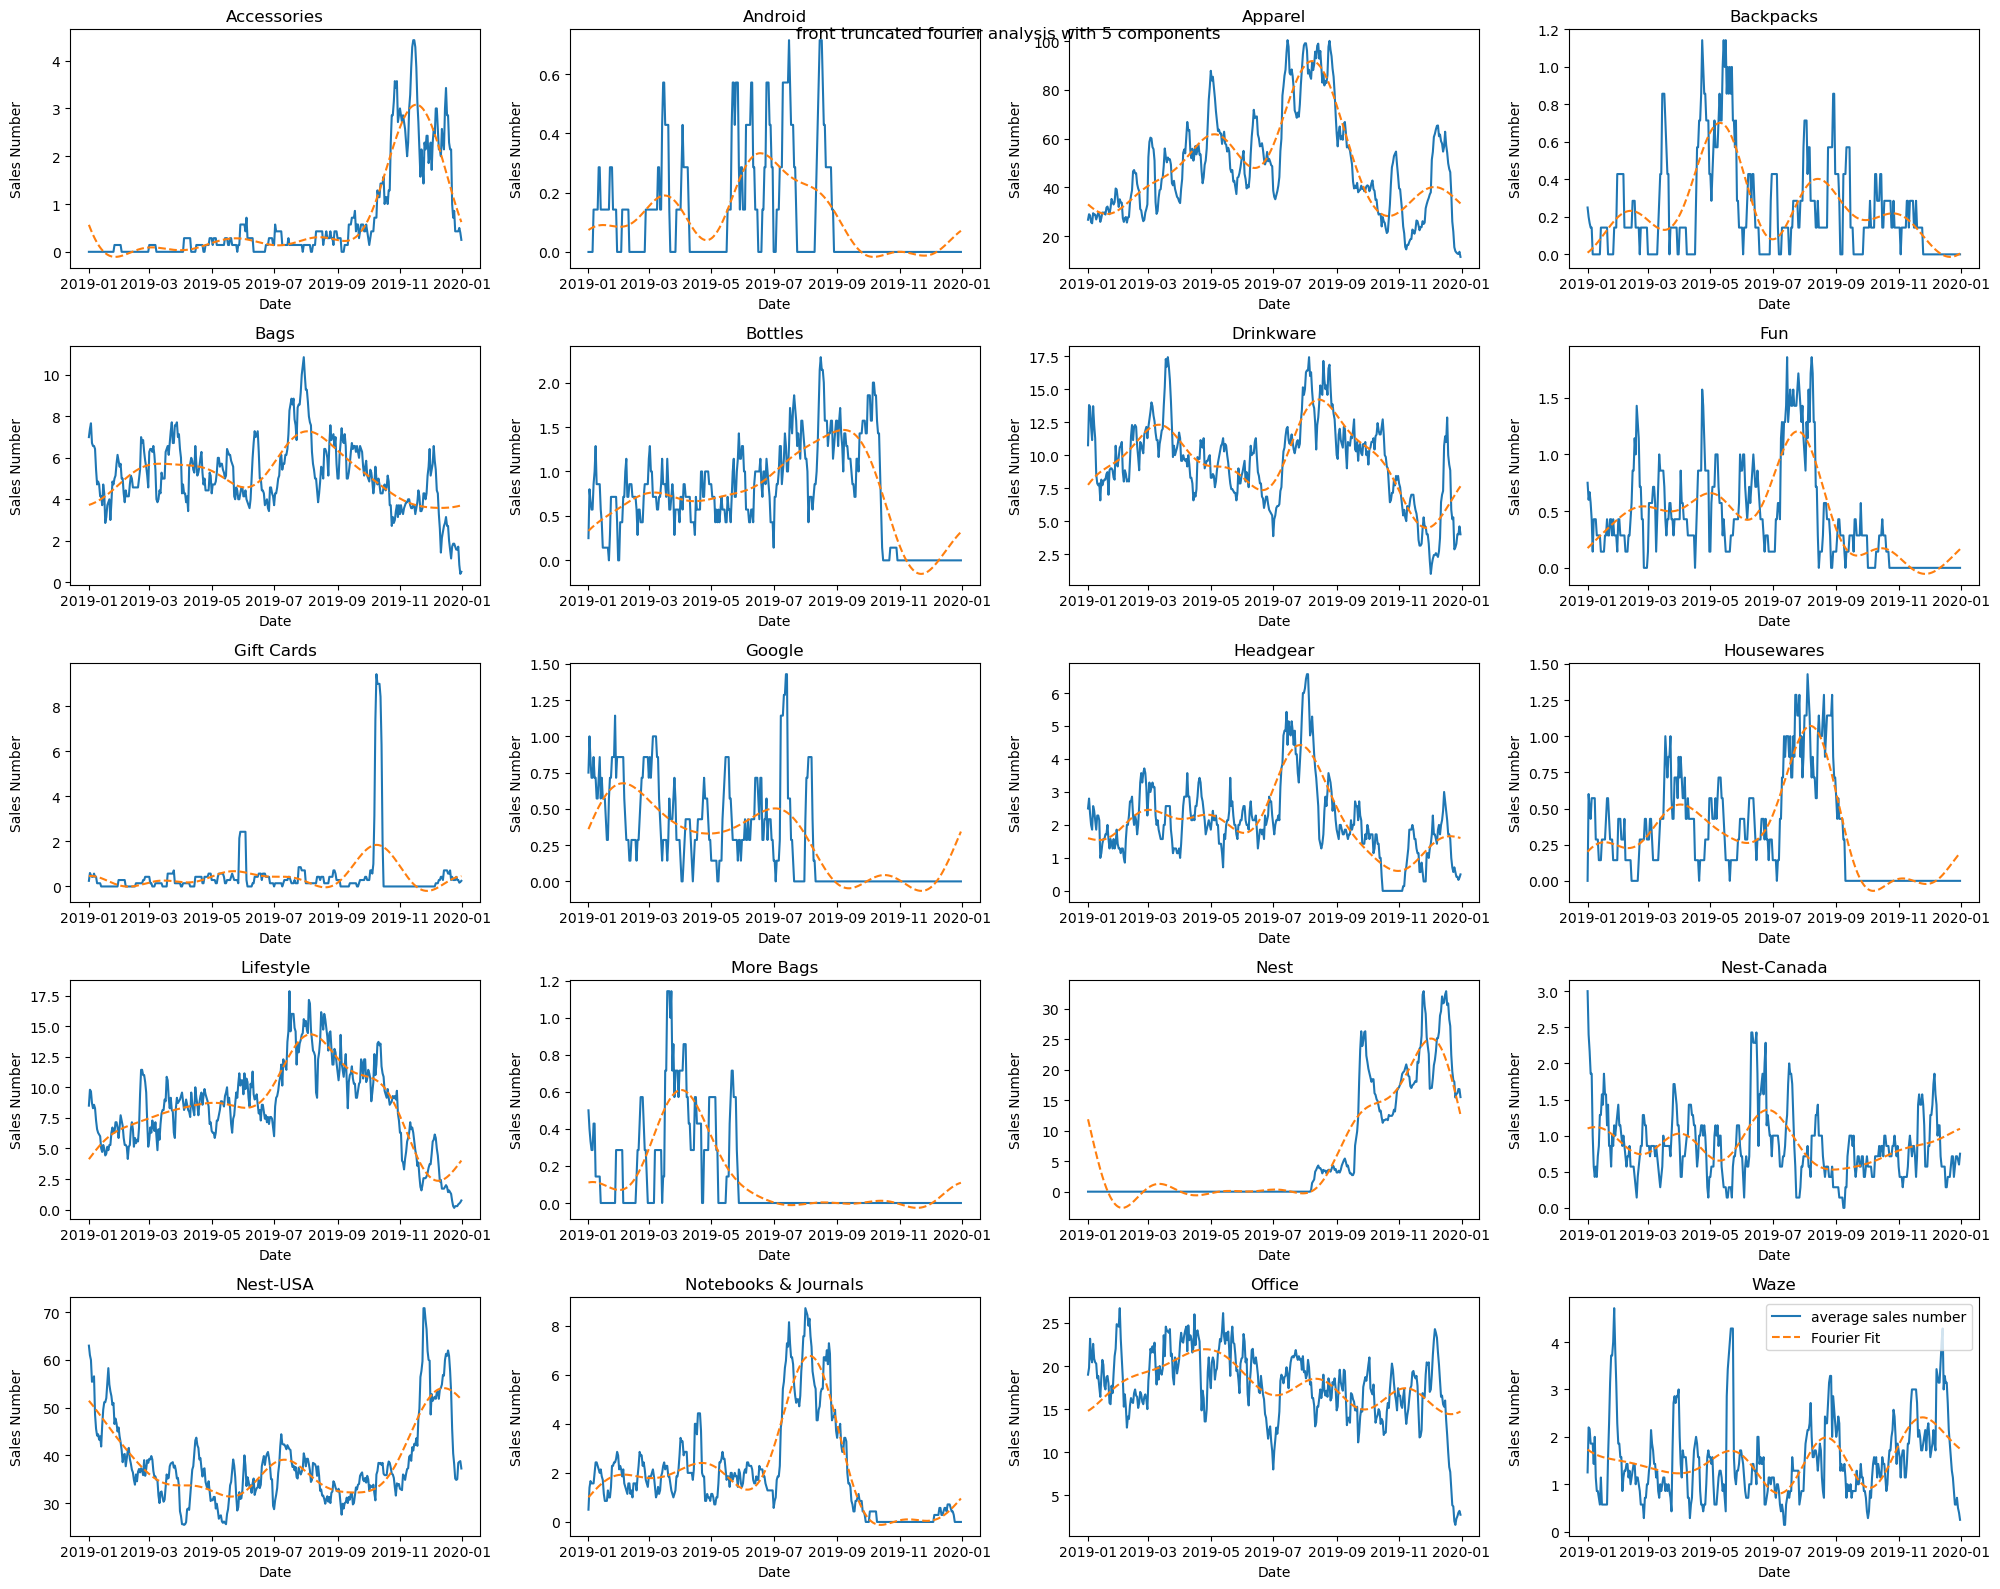

In [5]:
# we first take an array of complex values filled with zeros
front_truncated_fourier_values = np.zeros_like(true_fourier_values)
# we then add only the first FOURIER_COMPONENTS number of elements from each fourier analysis (and corresponding high frequency components) back in.
front_truncated_fourier_values[:, :FOURIER_COMPONENTS] = true_fourier_values[:, :FOURIER_COMPONENTS]
front_truncated_fourier_values[:, -FOURIER_COMPONENTS:] = true_fourier_values[:, -FOURIER_COMPONENTS:]

# we plot these to show the effect of using the front truncated fourier values compared to the roling average
data = df_rolling_avg.to_numpy()
fig, axs = plt.subplots(5, 4, figsize=(20, 16))
for x in range(5):
    for y in range(4):
        index = 4 * x + y
        sub_data = data.T[index]
        reconstructed_data = np.fft.ifft(front_truncated_fourier_values[index]).real
        axs[x, y].plot(df_rolling_avg.index, sub_data, label="average sales number")
        axs[x, y].plot(df_rolling_avg.index, reconstructed_data,
                            label='Fourier Fit', linestyle='--')
        axs[x, y].set_xlabel("Date")
        axs[x, y].set_ylabel("Sales Number")
        axs[x, y].set_title(df_rolling_avg.columns[index])
fig.align_labels()
plt.tight_layout()
plt.legend()
fig.suptitle(f"front truncated fourier analysis with {FOURIER_COMPONENTS} components")
plt.show()

Conversely if we take the other values (with lower magnitudes) we get the trend corrected data:

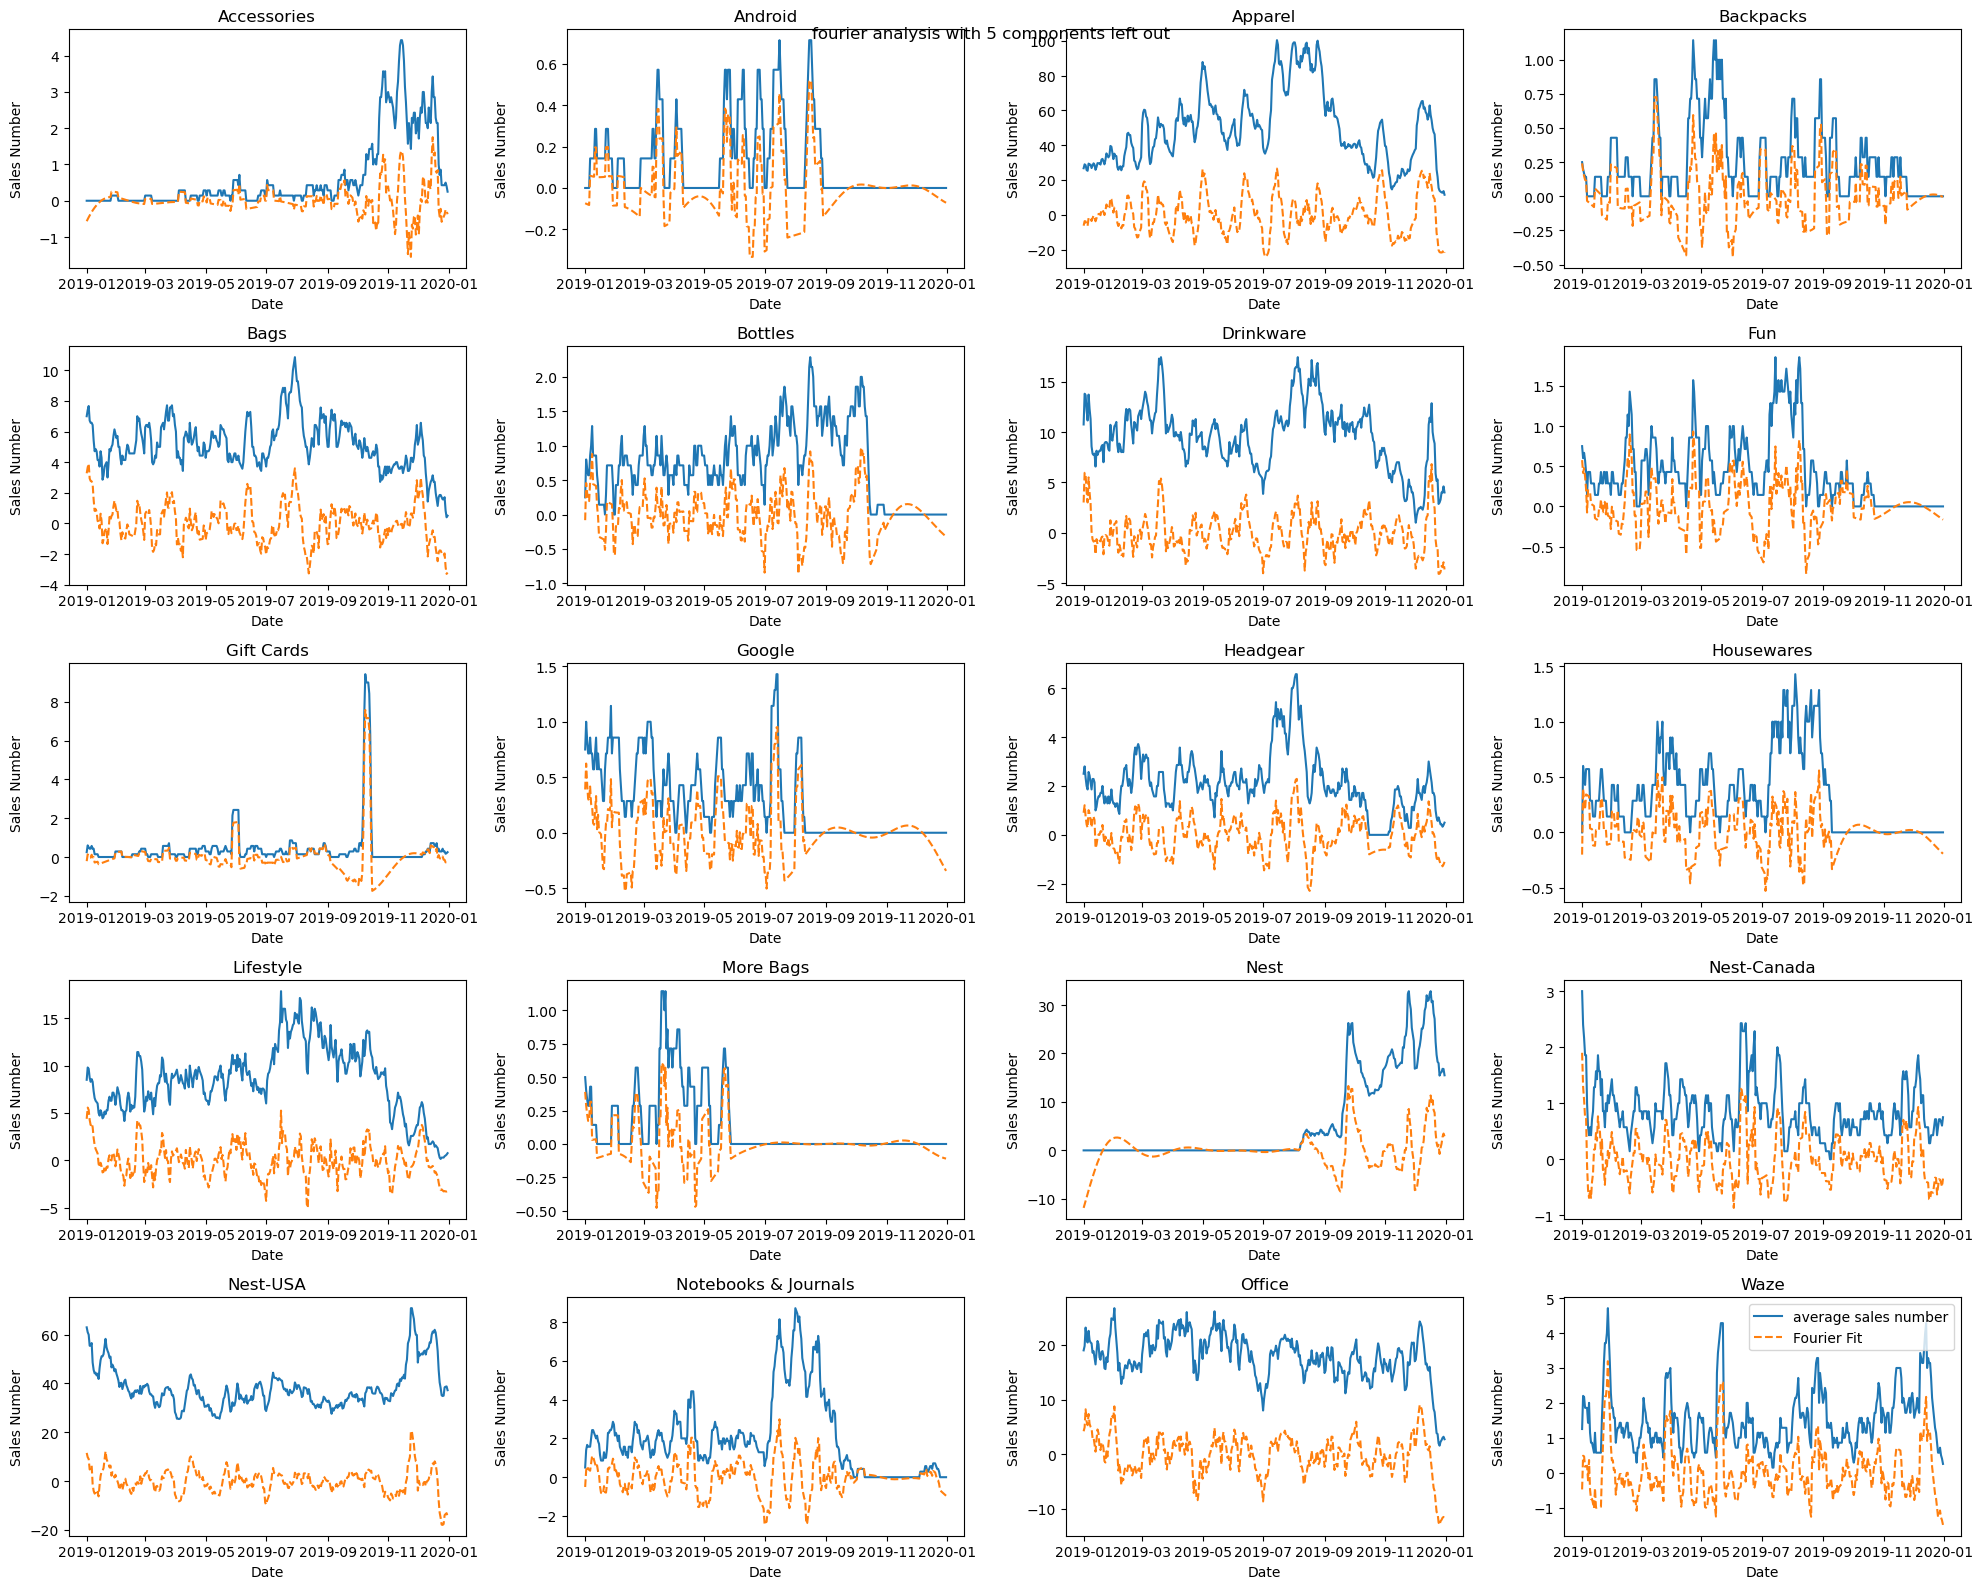

In [6]:
# we first take an array of complex values filled with zeros
center_truncated_fourier_values = np.zeros_like(true_fourier_values)
# we then add everything except the first and last FOURIER_COMPONENTS number of elements from each fourier analysis back in.
center_truncated_fourier_values[:, FOURIER_COMPONENTS:-FOURIER_COMPONENTS] = true_fourier_values[:, FOURIER_COMPONENTS:-FOURIER_COMPONENTS]

# we plot these to show the effect of using the end truncated fourier values compared to the roling average
data = df_rolling_avg.to_numpy()
reconstructed_data = []
fig, axs = plt.subplots(5, 4, figsize=(20, 16))
for x in range(5):
    for y in range(4):
        index = 4 * x + y
        sub_data = data.T[index]
        reconstructed_sub_data = np.fft.ifft(center_truncated_fourier_values[index]).real
        reconstructed_data.append(reconstructed_sub_data)
        axs[x, y].plot(df_rolling_avg.index, sub_data, label="average sales number")
        axs[x, y].plot(df_rolling_avg.index, reconstructed_sub_data,
                            label='Fourier Fit', linestyle='--')
        axs[x, y].set_xlabel("Date")
        axs[x, y].set_ylabel("Sales Number")
        axs[x, y].set_title(df_rolling_avg.columns[index])
fig.align_labels()
plt.tight_layout()
plt.legend()
fig.suptitle(f"fourier analysis with {FOURIER_COMPONENTS} components left out")
plt.show()

# clustering

Now we want to analyze the similarity between these trend corrected categories. 

For this we use the detrended data as vectors and do a cosine similarity.

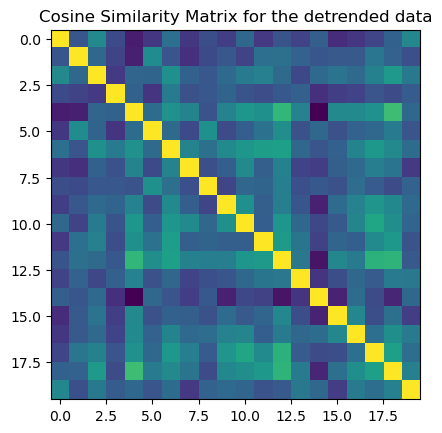

In [7]:
def cosine_similarity(vec_0, vec_1):
    dot_product = np.dot(vec_0, vec_1)
    magnitude_0 = np.linalg.norm(vec_0)
    magnitude_1 = np.linalg.norm(vec_1)
    return np.real(dot_product) / (magnitude_0 * magnitude_1)


def make_similarity_matrix(array, similarity_function):
    nr_to_compare = len(array)
    matrix = np.zeros((nr_to_compare, nr_to_compare))
    for index_0 in range(nr_to_compare):
        for index_1 in range(index_0, nr_to_compare):
            if index_0 == index_1:
                similarity = 1.0
                matrix[index_0, index_1] = similarity
            else:
                similarity = similarity_function(array[index_0], array[index_1])
                matrix[index_0, index_1] = similarity
                matrix[index_1, index_0] = similarity
    return matrix

magnitude_similarity_matrix = make_similarity_matrix(reconstructed_data, cosine_similarity)

plt.imshow(magnitude_similarity_matrix)
plt.title("Cosine Similarity Matrix for the detrended data")
plt.show()


We can do a clustering with this similarity matrix but we also have a direct measurement between two vectors, the euclidean distance.

In [8]:
# Convert similarity matrix to data pointsa
def similarity_to_points(similarity_matrix):
    """
    Convert a similarity matrix to 2D points using a simple method:
    Treat the rows as features and reduce dimensions via PCA-like logic.
    """
    # Standardize the matrix (mean = 0)
    standardized_matrix = similarity_matrix - np.mean(similarity_matrix, axis=0)
    # Calculate covariance matrix
    covariance_matrix = np.cov(standardized_matrix)
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # Take top 2 eigenvectors
    top_indices = np.argsort(eigenvalues)[-2:][::-1]
    top_components = eigenvectors[:, top_indices]
    # Transform data to 2D
    points_2d = np.dot(standardized_matrix, top_components)
    return points_2d

# K-means clustering
def kmeans(data, k, max_iter=100):
    """
    Args:
    - data: Array of shape (n_samples, n_features).
    - k: Number of clusters.
    - max_iter: Maximum number of iterations.
    
    Returns:
    - clusters: Cluster assignments for each point.
    - centers: Final cluster centers.
    """
    np.random.seed(42)
    n_samples = data.shape[0]
    
    # Randomly initialize cluster centers
    centers = data[np.random.choice(n_samples, k, replace=False)]
    
    for _ in range(max_iter):
        # Assign each point to the nearest center
        clusters = []
        for point in data:
            distances = np.linalg.norm(point - centers, axis=1) # Calculate the distance from data point to the center
            clusters.append(np.argmin(distances)) # Assign the point to the nearest center
        clusters = np.array(clusters)
        
        # Update cluster centers
        new_centers = np.array([data[clusters == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return clusters, centers

# Visualization
def visualize_clustering(data, labels, centers, n_clusters, point_labels):
    plt.figure(figsize=(10, 8))
    
    for i in range(n_clusters):
        cluster_points = data[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=100, alpha=0.7, label=f'Cluster {i+1}')
    
    # Add point labels directly
    for idx, (x, y) in enumerate(data):
        plt.text(x, y, point_labels[idx], fontsize=8, alpha=0.7, ha='center', va='center')
    
    # Plot cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', marker='X', label='Centers')
    
    plt.title('K-means Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

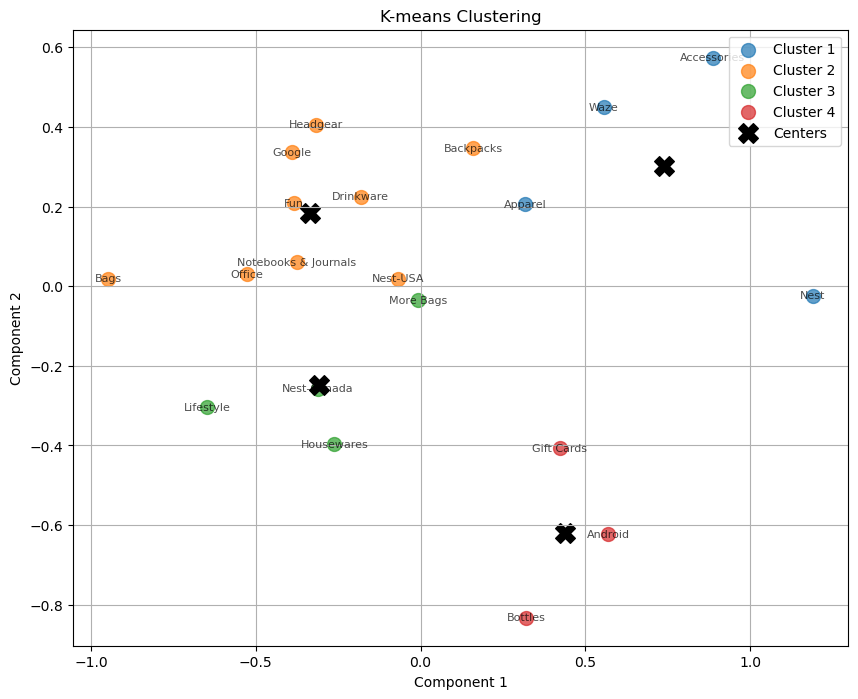

In [9]:
input_matrix = magnitude_similarity_matrix

# Convert similarity matrix to 2D points
points = similarity_to_points(input_matrix)

# K-means clustering
n_clusters = 4
labels, centers = kmeans(points, n_clusters)

# Visualize clustering
visualize_clustering(points, labels, centers, n_clusters, df_rolling_avg.columns)